<a href="https://colab.research.google.com/github/Sim98B/ShroomVision/blob/main/SV4/ShroomVision4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
try:
  import torch
  print(f"torch: {torch.__version__}")
  import torchvision
  print(f"torchvision: {torchvision.__version__}")
except:
  print("[INFO] Torch and Torchvision not installed, downloading")
  !pip install torch torchvision
  import torch
  import torchvision

import os
import zipfile
from pathlib import Path
import requests
import shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

!git clone https://github.com/Sim98B/ShroomVision
!mv ShroomVision/Modules/Libraries .

from Libraries import data, utils

shutil.rmtree("ShroomVision")

torch: 2.1.0+cu118
torchvision: 0.16.0+cu118
Cloning into 'ShroomVision'...
remote: Enumerating objects: 2259, done.
remote: Counting objects: 100% (712/712), done.
remote: Compressing objects: 100% (557/557), done.
remote: Total 2259 (delta 188), reused 566 (delta 131), pack-reused 1547
Receiving objects: 100% (2259/2259), 247.75 MiB | 32.31 MiB/s, done.
Resolving deltas: 100% (324/324), done.
Updating files: 100% (1456/1456), done.
mv: cannot move 'ShroomVision/Modules/Libraries' to './Libraries': Directory not empty


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [14]:
data_path = data.download_data(source = "https://github.com/Sim98B/ShroomVision/raw/main/Data/SV4_data.zip",
                               remove_source = True)

train_dir = data_path.joinpath("train_data")
val_dir = data_path.joinpath("val_data")
test_dir = data_path.joinpath("test_data")
data_path

[INFO] data directory exists.
[INFO] Downloading SV4_data.zip from https://github.com/Sim98B/ShroomVision/raw/main/Data/SV4_data.zip...
[INFO] Unzipping SV4_data.zip data...


PosixPath('data/SV4_data')

In [15]:
data.inspect_dir(data_path)

There are 3 directory/ies and 0 file/s in data/SV4_data
There are 4 directory/ies and 0 file/s in data/SV4_data/train_data
There are 0 directory/ies and 200 file/s in data/SV4_data/train_data/amanita_vaginata
There are 0 directory/ies and 200 file/s in data/SV4_data/train_data/amanita_muscaria
There are 0 directory/ies and 200 file/s in data/SV4_data/train_data/boletus_edulis
There are 0 directory/ies and 200 file/s in data/SV4_data/train_data/boletus_erythropus
There are 4 directory/ies and 0 file/s in data/SV4_data/test_data
There are 0 directory/ies and 51 file/s in data/SV4_data/test_data/amanita_vaginata
There are 0 directory/ies and 172 file/s in data/SV4_data/test_data/amanita_muscaria
There are 0 directory/ies and 111 file/s in data/SV4_data/test_data/boletus_edulis
There are 0 directory/ies and 39 file/s in data/SV4_data/test_data/boletus_erythropus
There are 4 directory/ies and 0 file/s in data/SV4_data/val_data
There are 0 directory/ies and 64 file/s in data/SV4_data/val_dat

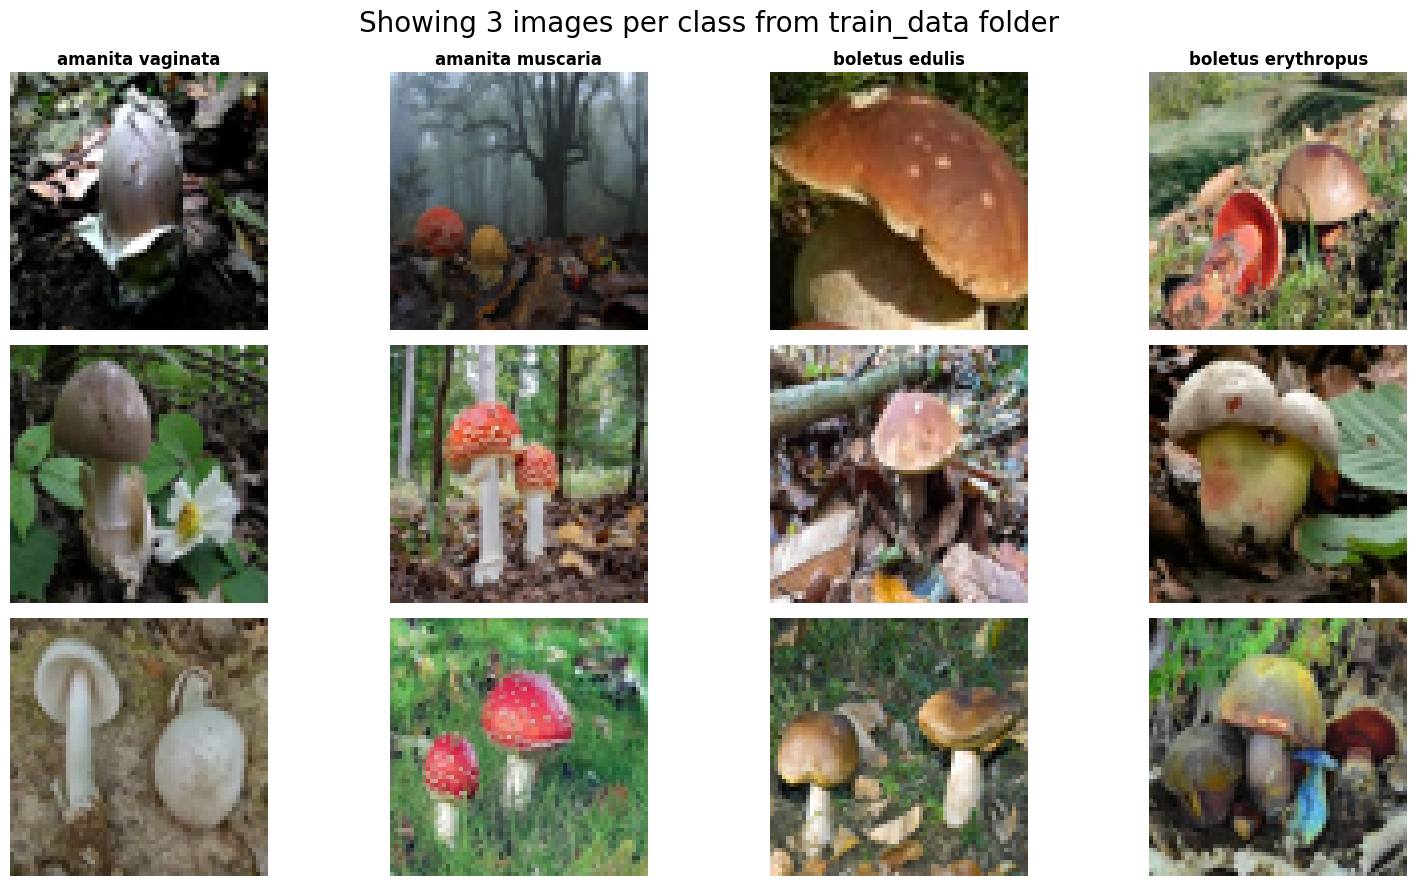

In [76]:
data.plot_random_images(data_path = data_path,
                        target_folder = "train_data",
                        img_size = (64, 64))

In [23]:
sv4_transformer = transforms.Compose([transforms.Resize(size=(64, 64)),
                                 transforms.ToTensor()])

In [24]:
train_loader, class_names  = data.dataloader(train_dir, transformer = sv4_transformer, bs = 32, shuffle = True)
val_loader,_  = data.dataloader(val_dir, transformer = sv4_transformer, bs = 32, shuffle = False)
test_loader,_  = data.dataloader(test_dir, transformer = sv4_transformer, bs = 32, shuffle = False)

train_loader, val_loader, test_loader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78f9da346b60>,
 ['amanita_muscaria',
  'amanita_vaginata',
  'boletus_edulis',
  'boletus_erythropus'])

In [83]:
for batch_idx, (immagini, etichette) in enumerate(train_loader):
    # `immagini` è un tensore contenente il batch di immagini
    # `etichette` è un tensore contenente le etichette di classe per le immagini

    # Accedi a un'immagine specifica nel batch, ad esempio la prima immagine
    prima_immagine = immagini[0]

    # Puoi fare ulteriori operazioni con l'immagine, ad esempio visualizzarla utilizzando matplotlib
  plt.imshow(prima_immagine.permute(1, 2, 0))  # Cambia il formato del tensore per adattarlo a matplotlib (C x H x W -> H x W x C)
  plt.title(f'Etichetta: {etichette[0]}')  # Mostra l'etichetta della prima immagine
  plt.show()

IndentationError: ignored

In [70]:
def linear_baseline(input_shape: int,
                    output_shape: int,
                    num_layers: int = 3,
                    num_neurons: int = 10):
  """
  Creates a multi layer linear torch neural network to be used as baseline

  Args:
    iput_shape (int):
  """
  class baseline(nn.Module):
    def __init__(self, input_shape, output_shape, num_layers, num_neurons):
      super().__init__()
      layers = []
      for _ in range(num_layers):
        layers.append(nn.Linear(num_neurons, num_neurons))
        layers.append(nn.ReLU())
      self.hidden_layers = nn.Sequential(nn.Flatten(),*layers)
      self.output_layer = nn.Linear(num_neurons, output_shape)

    def forward(self, x):
      x = self.hidden_layers(x)
      x = self.output_layer(x)
      return x

  modello = baseline(input_shape, output_shape, num_layers, num_neurons)
  return modello

In [71]:
model = linear_baseline(3,4)
model

baseline(
  (hidden_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=10, bias=True)
    (6): ReLU()
  )
  (output_layer): Linear(in_features=10, out_features=4, bias=True)
)